# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    self.dropout1 = tf.keras.layers.Dropout(0.5)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    self.dropout2 = tf.keras.layers.Dropout(0.5)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.dropout1(x)
    x = self.layer2(x, activation=0)
    x = self.dropout2(x)
    x = self.out_layer(x, activation=1)


    return x

In [10]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Зробимо порівняння передбачених значеннь з істинними лейблами
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    # Визначимо середню точність використовуючи метод згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [11]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [12]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Крок: {step}, Функція втрат: {loss}, Точність: {acc}")


Крок: 100, Функція втрат: 306.18817138671875, Точність: 0.69921875
Крок: 200, Функція втрат: 210.5626983642578, Точність: 0.75390625
Крок: 300, Функція втрат: 185.638427734375, Точність: 0.7890625
Крок: 400, Функція втрат: 156.40013122558594, Точність: 0.8125
Крок: 500, Функція втрат: 127.87936401367188, Точність: 0.85546875
Крок: 600, Функція втрат: 173.40585327148438, Точність: 0.81640625
Крок: 700, Функція втрат: 106.77058410644531, Точність: 0.8828125
Крок: 800, Функція втрат: 135.7087860107422, Точність: 0.82421875
Крок: 900, Функція втрат: 131.62738037109375, Точність: 0.8828125
Крок: 1000, Функція втрат: 106.95710754394531, Точність: 0.89453125
Крок: 1100, Функція втрат: 120.93194580078125, Точність: 0.859375
Крок: 1200, Функція втрат: 70.24234008789062, Точність: 0.91015625
Крок: 1300, Функція втрат: 102.14390563964844, Точність: 0.8671875
Крок: 1400, Функція втрат: 68.2030258178711, Точність: 0.92578125
Крок: 1500, Функція втрат: 90.11981964111328, Точність: 0.921875
Крок: 160

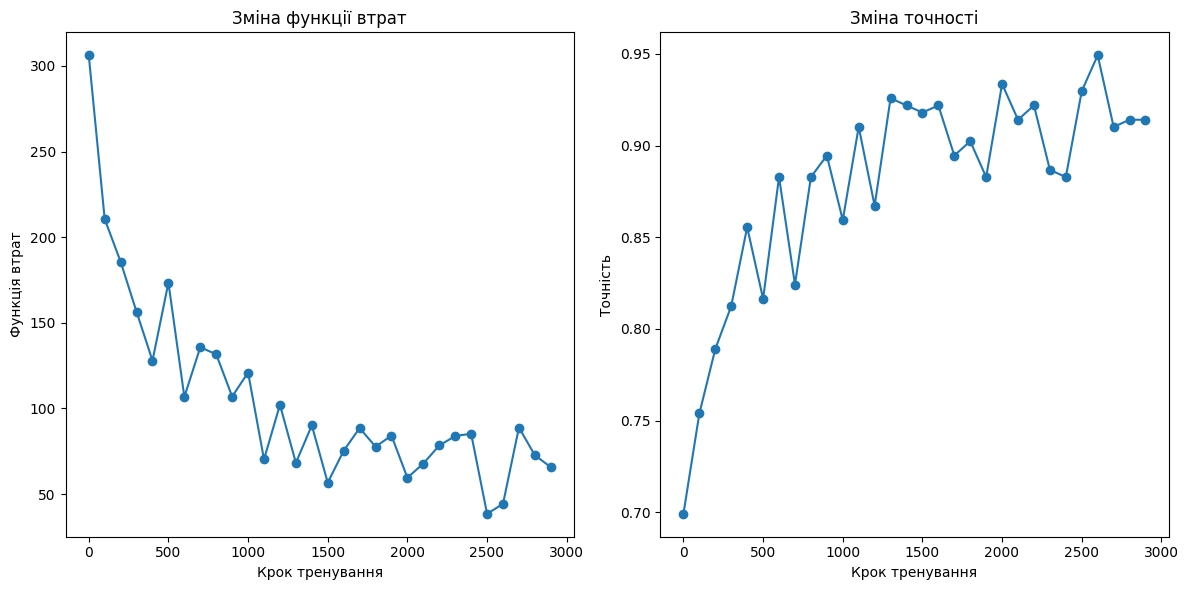

In [14]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt


# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Зміна функції втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Зміна точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')

plt.tight_layout()
plt.show()


In [36]:
# # Обчисліть точність навченої нейромережі
from sklearn.metrics import classification_report

# Отримуємо прогнози моделі для тестових зображень
predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виводимо класифікаційний звіт
print(classification_report(y_test, predicted_labels))


predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Обчислюємо матрицю плутанини
cm = confusion_matrix(y_test, predicted_labels)

# Виводимо матрицю плутанини
print("Матриця плутанини:")
print(cm)


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.97      0.98      0.97      1135
           2       0.90      0.89      0.89      1032
           3       0.88      0.88      0.88      1010
           4       0.91      0.89      0.90       982
           5       0.90      0.84      0.87       892
           6       0.92      0.93      0.92       958
           7       0.91      0.92      0.91      1028
           8       0.84      0.89      0.86       974
           9       0.87      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Матриця плутанини:
[[ 928    1    7    3    5    7   14    5   10    0]
 [   0 1107    6    5    0    1    2    3   11    0]
 [   7    6  916   23    9    4   13   17   35    2]
 [   1    4   25  892    2   33    3   14   22   14]
 [   1    

In [37]:
# Обчислюємо та виводимо загальну точність на тестових даних
correct_predictions = (predicted_labels == y_test)
test_accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на тестових даних складає: {test_accuracy * 100:.2f}%")

Точність на тестових даних складає: 90.44%


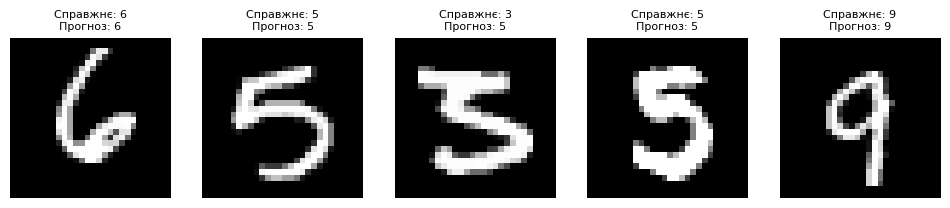

In [28]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?


import random
import matplotlib.pyplot as plt

# Оберемо кілька (10) випадкових зображень з тестової вибірки
random_indices = random.sample(range(len(x_test)), 10)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Обчислимо прогнози класів для вибраних зображень
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Справжнє: {test_labels[i]}\nПрогноз: {predicted_labels[i]}", fontsize=8)
    plt.axis('off')

plt.show()

# Порівняємо прогнози з правильними лейблами та обчислимо точність
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)




**Відповідь:**



*   Точність нейромережі на тестових даних складає 90.44%, що є високим показником для короткого часу навчання, але ще не ідеальним для справжніх задач.Тому слід бути уважним з результатами, які вона видає.
*   Провівши порівняння прогнозів із правильними значеннями можемо дійти висновку, що модель навчена досить добре,можливо навіть близько до людського погляду на числа, але не ідеально.

Тим не менш вона помиляється орієнтовно 1 раз з 5-ти, та і на таких значеннях, що є неочевидними навіть для людини. Все через значну схожість з іншими значеннями, які мають щільне скупчення пікселів в області, що ускладнює їх розпізнавання

